In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Conv1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.regularizers import l2

In [4]:
# Setting up stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [5]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import random

# Setting up lemmatizer
lemmatizer = WordNetLemmatizer()

# Helper function for synonym replacement
def synonym_replacement(word):
    synonyms = wordnet.synsets(word)
    if synonyms:
        synonym = random.choice(synonyms).lemmas()[0].name()
        return synonym.replace('_', ' ')
    return word

# Modified preprocessing function
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove hashtags and mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower()  # Convert to lower case
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    augmented_text = ' '.join([synonym_replacement(word) if random.random() < 0.1 else word for word in words])
    return augmented_text


In [6]:
# Function to visualize model training history
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
#Function to draw confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.4)  # Increase font size for better readability

    # Create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Proportion'})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [8]:
# Loading train, test, and validation data
train = pd.read_csv('/content/train.txt', delimiter=';', header=None)
test = pd.read_csv('/content/test.txt', delimiter=';', header=None)
val = pd.read_csv('/content/val.txt', delimiter=';', header=None)

In [9]:
print(f"Shape of training data is {train.shape}")
print(f"Shape of testing data is {test.shape}")
print(f"Shape of validation data is {val.shape}")

Shape of training data is (16000, 2)
Shape of testing data is (2000, 2)
Shape of validation data is (2000, 2)


In [10]:
train.rename(columns={0: 'text', 1: 'label'}, inplace=True)
test.rename(columns={0: 'text', 1: 'label'}, inplace=True)
val.rename(columns={0: 'text', 1: 'label'}, inplace=True)

In [11]:
train

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [12]:
sentence_lengths = [len(sentence.split()) for sentence in train['text']]

In [13]:
import numpy as np
max_len = int(np.percentile(sentence_lengths, 95))
print(max_len)

41


In [14]:
train['label'].value_counts(ascending = True)

,count
label,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


In [15]:
test['label'].value_counts(ascending = True)

,count
label,
surprise,66
love,159
fear,224
anger,275
sadness,581
joy,695


In [16]:
val['label'].value_counts(ascending = True)

,count
label,
surprise,81
love,178
fear,212
anger,275
sadness,550
joy,704


<Axes: xlabel='label'>

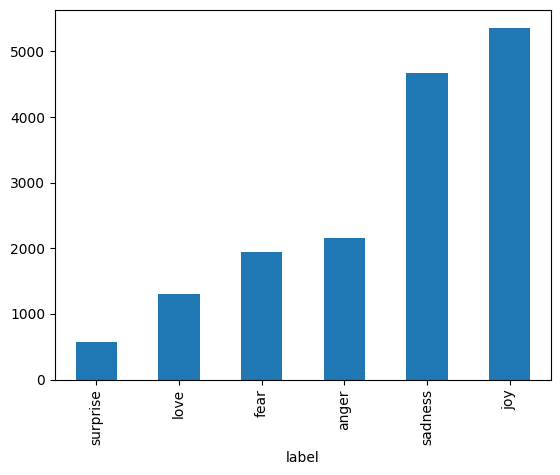

In [17]:
train['label'].value_counts().sort_values(ascending = True).plot(kind = 'bar')

<Axes: xlabel='label'>

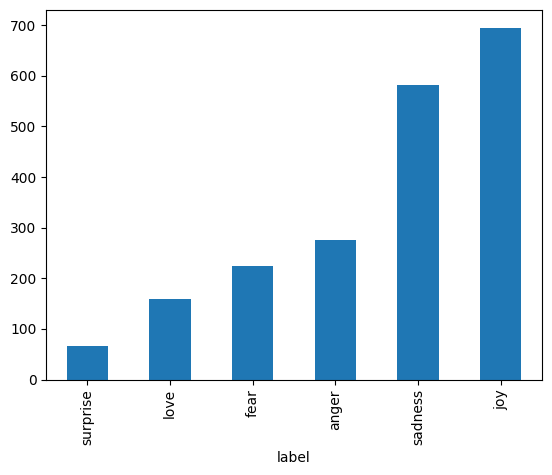

In [18]:
test['label'].value_counts(ascending = True).plot(kind = 'bar')

<Axes: xlabel='label'>

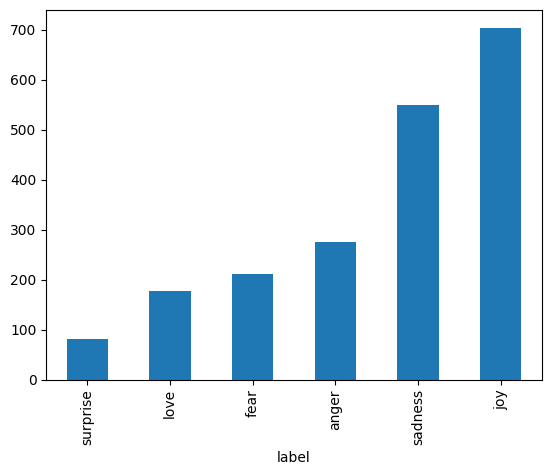

In [19]:
val['label'].value_counts(ascending = True).plot(kind = 'bar')

In [20]:
train[train['label'] == 'joy'].head()

,text,label
8,i have been with petronas for years i feel tha...,joy
11,i do feel that running is a divine experience ...,joy
14,i have immense sympathy with the general point...,joy
15,i do not feel reassured anxiety is on each side,joy
22,i have the feeling she was amused and delighted,joy


In [21]:
train[train['label'] == 'sadness'].head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
5,ive been feeling a little burdened lately wasn...,sadness
10,i feel like i have to make the suffering i m s...,sadness
13,i feel low energy i m just thirsty,sadness


In [22]:
train[train['label'] == 'anger'].head()

,text,label
2,im grabbing a minute to post i feel greedy wrong,anger
4,i am feeling grouchy,anger
12,i think it s the easiest time of year to feel ...,anger
20,i feel irritated and rejected without anyone d...,anger
24,i already feel like i fucked up though because...,anger


In [23]:
train[train['label'] == 'fear'].head()

,text,label
7,i feel as confused about life as a teenager or...,fear
19,i now feel compromised and skeptical of the va...,fear
21,i am feeling completely overwhelmed i have two...,fear
31,i remember feeling acutely distressed for a fe...,fear
53,i was stymied a little bit as i wrote feeling ...,fear


In [24]:
train[train['label'] == 'love'].head()

,text,label
3,i am ever feeling nostalgic about the fireplac...,love
9,i feel romantic too,love
47,i can t let go of that sad feeling that i want...,love
61,i ate i could feel a gentle tingle throughout ...,love
68,i suppose my own truth needs to be shared i ha...,love


In [25]:
train[train['label'] == 'surprise'].head()

,text,label
6,ive been taking or milligrams or times recomme...,surprise
32,i have seen heard and read over the past coupl...,surprise
57,i keep feeling pleasantly surprised at his sup...,surprise
64,i am now nearly finished the week detox and i ...,surprise
129,i too feel as if i am a stranger in a strange ...,surprise


In [26]:
# Drop duplicates from the datasets
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
val.drop_duplicates(inplace=True)

In [27]:
# Drop rows with missing values
train.dropna(inplace=True)
test.dropna(inplace=True)
val.dropna(inplace=True)

In [28]:
# Preprocess the text data
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)
val['text'] = val['text'].apply(preprocess_text)

In [29]:
train['text'] = train['text'].apply(synonym_replacement)
test['text'] = test['text'].apply(synonym_replacement)
val['text'] = val['text'].apply(synonym_replacement)

In [30]:
print(f"Shape of training data is {train.shape}")
print(f"Shape of testing data is {test.shape}")
print(f"Shape of validation data is {val.shape}")

Shape of training data is (15999, 2)
Shape of testing data is (2000, 2)
Shape of validation data is (2000, 2)


In [31]:
# Extract tweets and labels
def get_tweet(data):
    tweets = [x for x in data['text']]
    labels = [x for x in data['label']]
    return tweets, labels

tweets, labels = get_tweet(train)

In [32]:
# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [33]:
def get_sequences(tokenizer, tweets):
    sequence = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    return padded

In [34]:
# Preparing data sequences
X_train = get_sequences(tokenizer, tweets)
test_tweets, test_labels = get_tweet(test)
X_test = get_sequences(tokenizer, test_tweets)
val_tweets, val_labels = get_tweet(val)
X_val = get_sequences(tokenizer, val_tweets)

In [35]:
# Converting labels to NumPy arrays
y_train = np.array(labels)
y_test = np.array(test_labels)
y_val = np.array(val_labels)

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15999, 41)
(15999,)
(2000, 41)
(2000,)
(2000, 41)
(2000,)


In [37]:
np.unique(y_train)

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [38]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}


In [39]:
class_weights_dict['anger'] = class_weights_dict['anger'] * 0.5
class_weights_dict

{'anger': 0.6175312644742936,
 'fear': 1.3766133195663397,
 'joy': 0.49738854691288936,
 'love': 2.044861963190184,
 'sadness': 0.5714744963566224,
 'surprise': 4.661713286713287}

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [41]:
y_train[0]

4

In [42]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=6)
y_val_encoded = to_categorical(y_val, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

In [43]:
y_train_encoded[0]

array([0., 0., 0., 0., 1., 0.])

In [44]:
print(f"Shape of X_train is : {X_train.shape}")
print(f"Shape of X_test is : {X_test.shape}")
print(f"Shape of X_val is : {X_val.shape}")
print(f"Shape of y_train is : {y_train.shape}")
print(f"Shape of y_test is : {y_test.shape}")
print(f"Shape of y_val is : {y_val.shape}")
print(f"Shape of y_train_encoded is : {y_train_encoded.shape}")
print(f"Shape of y_val_encoded is : {y_val_encoded.shape}")
print(f"Shape of y_test_encoded is : {y_test_encoded.shape}")

Shape of X_train is : (15999, 41)
Shape of X_test is : (2000, 41)
Shape of X_val is : (2000, 41)
Shape of y_train is : (15999,)
Shape of y_test is : (2000,)
Shape of y_val is : (2000,)
Shape of y_train_encoded is : (15999, 6)
Shape of y_val_encoded is : (2000, 6)
Shape of y_test_encoded is : (2000, 6)


In [45]:
le.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [46]:
labels_dict = {0:'anger', 1:'fear', 2:'joy', 3:'love', 4:'sadness', 5:'surprise'}

In [47]:
#Setting the hyperparameters based of dataset

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
max_length = max_len

**LSTM** **1**

In [55]:
#Model Lstm 1

model_lstm_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model_lstm_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model_lstm_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
history_model_lstm_1 = model_lstm_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.3927 - loss: 1.4786 - val_accuracy: 0.8305 - val_loss: 0.4948
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8716 - loss: 0.3766 - val_accuracy: 0.9005 - val_loss: 0.3068
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9336 - loss: 0.1854 - val_accuracy: 0.9040 - val_loss: 0.2712
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9565 - loss: 0.1167 - val_accuracy: 0.8975 - val_loss: 0.3386
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9622 - loss: 0.1039 - val_accuracy: 0.8995 - val_loss: 0.3220
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9747 - loss: 0.0769 - val_accuracy: 0.8985 - val_loss: 0.3293
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9767 - loss: 0.0640 - val_accuracy: 0.9000 - val_loss: 0.3906
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9823 - loss: 0.0577 - 

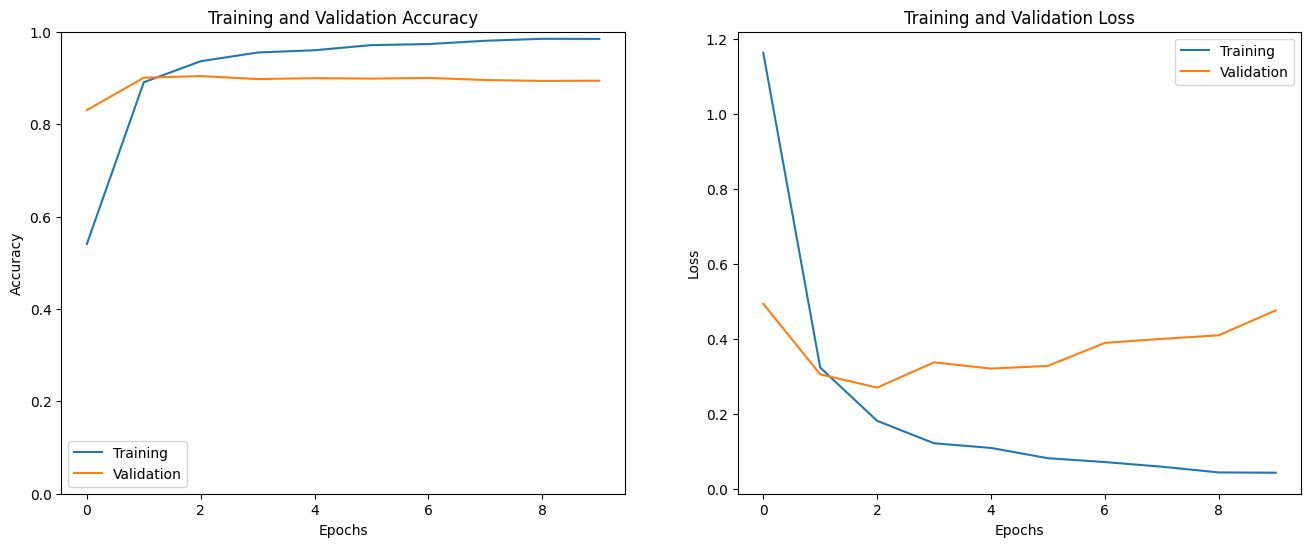

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8965 - loss: 0.4507
Test Loss: 0.4684907793998718
Test Accuracy: 0.890500009059906
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.89      0.89       275
        fear       0.87      0.81      0.84       224
         joy       0.94      0.91      0.93       695
        love       0.73      0.82      0.77       159
     sadness       0.93      0.93      0.93       581
    surprise       0.60      0.79      0.68        66

    accuracy                           0.89      2000
   macro avg       0.83      0.86      0.84      2000
weighted avg       0.90      0.89      0.89      2000



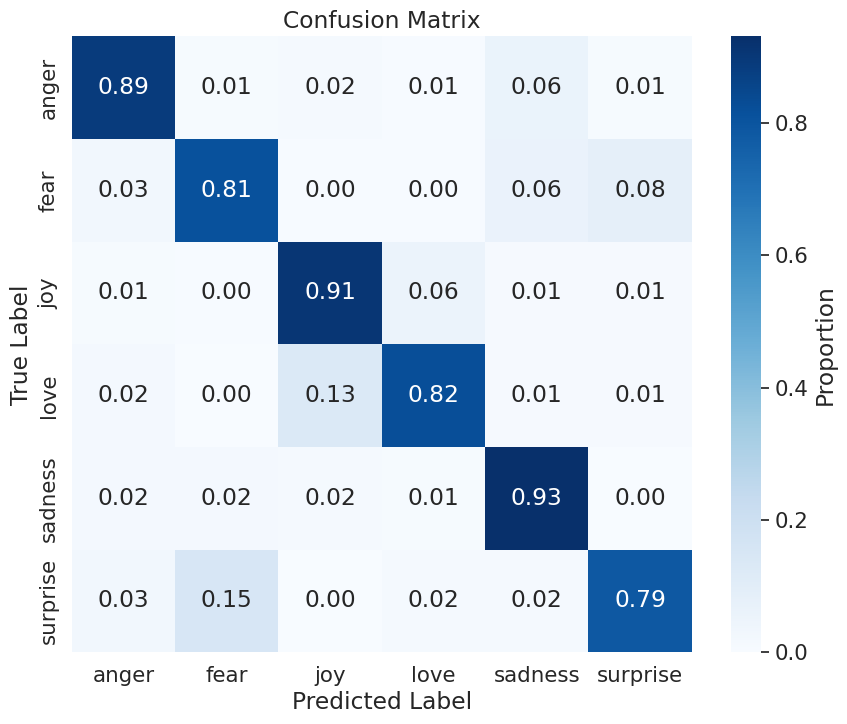

In [57]:
# Visualize training history
show_history(history_model_lstm_1)

# Evaluating the model
loss, accuracy = model_lstm_1.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_lstm_1.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_lstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(y_test, y_pred_classes_lstm, classes=list(labels_dict.values()))

**GRU**

In [58]:
def create_enhanced_gru_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(Bidirectional(GRU(128, return_sequences=True)))  # Bidirectional GRU
    model.add(GlobalMaxPooling1D())  # Global Max Pooling
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))  # Dense layer for more complexity
    model.add(Dropout(0.5))  # Another Dropout layer
    model.add(Dense(6, activation='softmax'))  # Output layer for multi-class classification

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_enhanced_gru = create_enhanced_gru_model(vocab_size, embedding_dim, 100)

model_enhanced_gru.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history_model_gru = model_enhanced_gru.fit(X_train,
                                  y_train_encoded,
                                  epochs=20,
                                  batch_size=32,
                                  validation_data=(X_val, y_val_encoded),
                                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                                  class_weight=class_weights_dict,
                                           )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4459 - loss: 1.3819 - val_accuracy: 0.8780 - val_loss: 0.3541
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9050 - loss: 0.2964 - val_accuracy: 0.9120 - val_loss: 0.2388
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9452 - loss: 0.1618 - val_accuracy: 0.9120 - val_loss: 0.2577
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9629 - loss: 0.1057 - val_accuracy: 0.9045 - val_loss: 0.3045
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9705 - loss: 0.0839 - val_accuracy: 0.9080 - val_loss: 0.3084


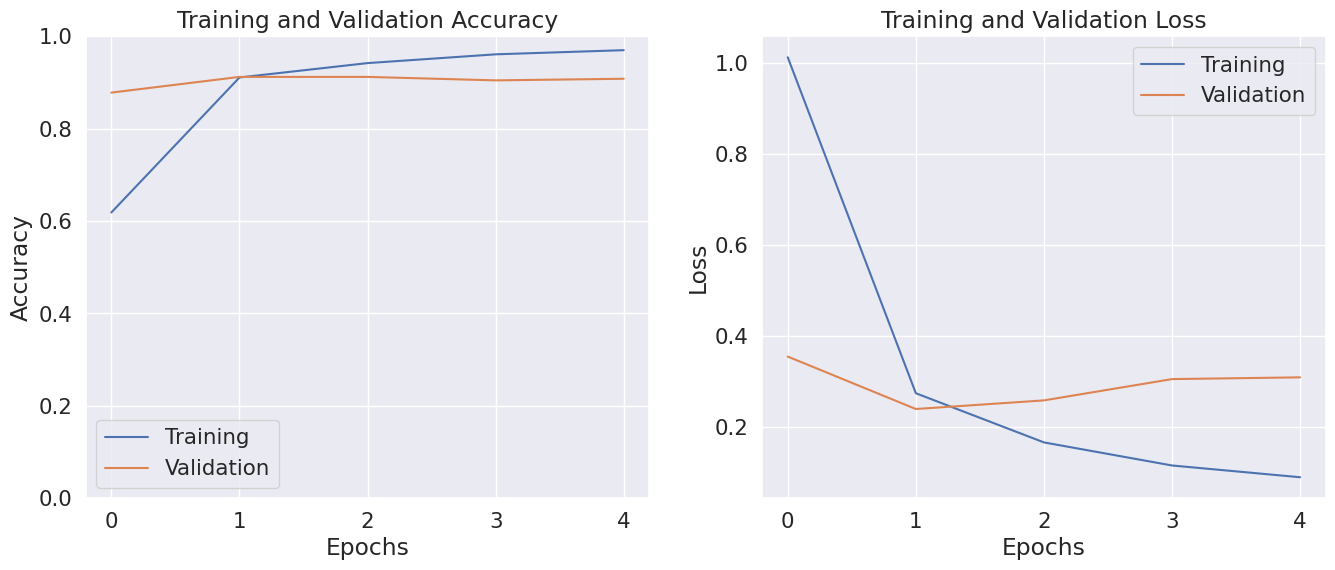

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9085 - loss: 0.2291
Test Loss: 0.22211049497127533
Test Accuracy: 0.9114999771118164
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.92      0.91       275
        fear       0.88      0.89      0.88       224
         joy       0.94      0.94      0.94       695
        love       0.75      0.85      0.80       159
     sadness       0.95      0.94      0.95       581
    surprise       0.86      0.56      0.68        66

    accuracy                           0.91      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.91      0.91      0.91      2000



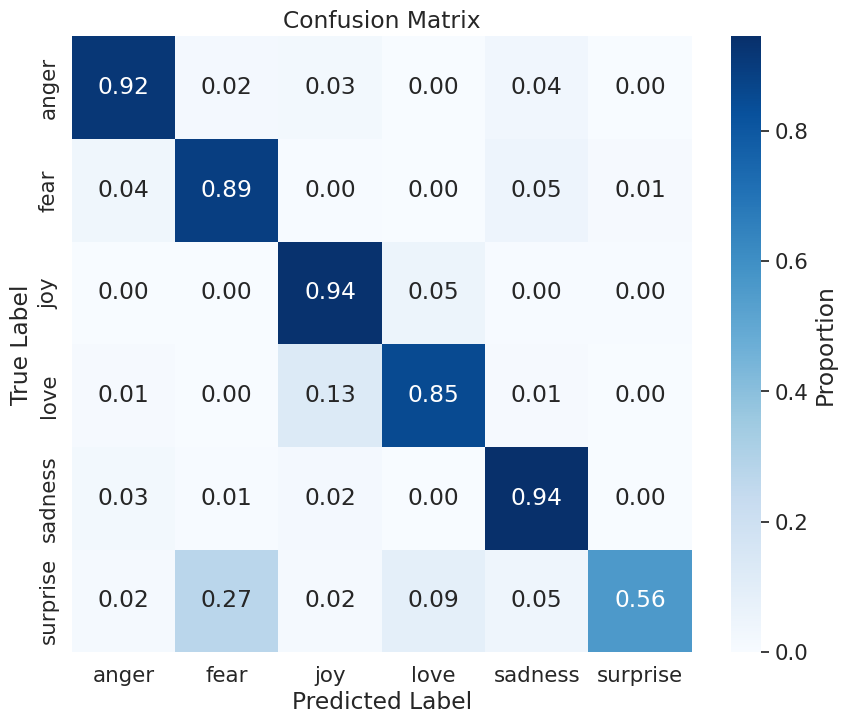

In [60]:
# Visualize training history
show_history(history_model_gru)

# Evaluating the model
loss, accuracy = model_enhanced_gru.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_enhanced_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_gru, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(y_test, y_pred_classes_gru, classes=list(labels_dict.values()))

**CNN**

In [61]:
def create_cnn_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))
    return model

model_cnn = create_cnn_model(vocab_size, embedding_dim, max_len)

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train the CNN model
history_model_cnn = model_cnn.fit(X_train,
                         y_train_encoded,
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_val, y_val_encoded),
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.4125 - loss: 1.4245 - val_accuracy: 0.7220 - val_loss: 0.6738
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7752 - loss: 0.5559 - val_accuracy: 0.8765 - val_loss: 0.3751
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9231 - loss: 0.2288 - val_accuracy: 0.8845 - val_loss: 0.3551
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9558 - loss: 0.1334 - val_accuracy: 0.8850 - val_loss: 0.3936
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9735 - loss: 0.0790 - val_accuracy: 0.8940 - val_loss: 0.4517
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9791 - loss: 0.0676 - val_accuracy: 0.8890 - val_loss: 0.5523


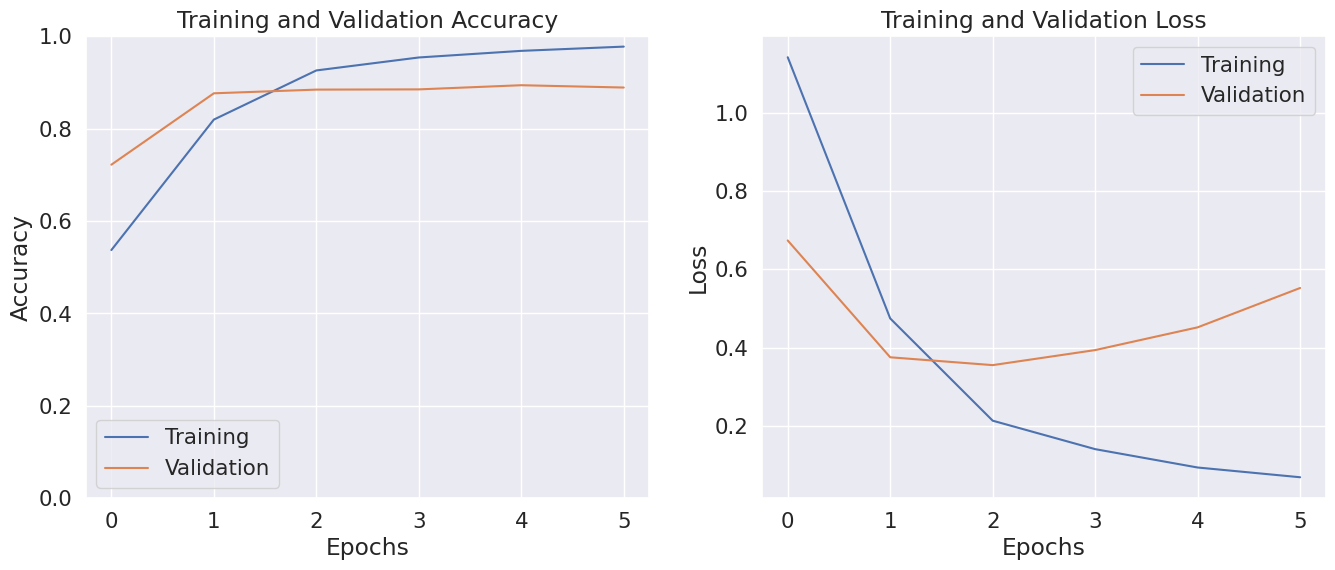

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.3181
Test Loss: 0.3084719777107239
Test Accuracy: 0.887499988079071
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.86      0.88       275
        fear       0.79      0.81      0.80       224
         joy       0.92      0.94      0.93       695
        love       0.80      0.77      0.78       159
     sadness       0.95      0.91      0.93       581
    surprise       0.59      0.79      0.68        66

    accuracy                           0.89      2000
   macro avg       0.83      0.85      0.83      2000
weighted avg       0.89      0.89      0.89      2000



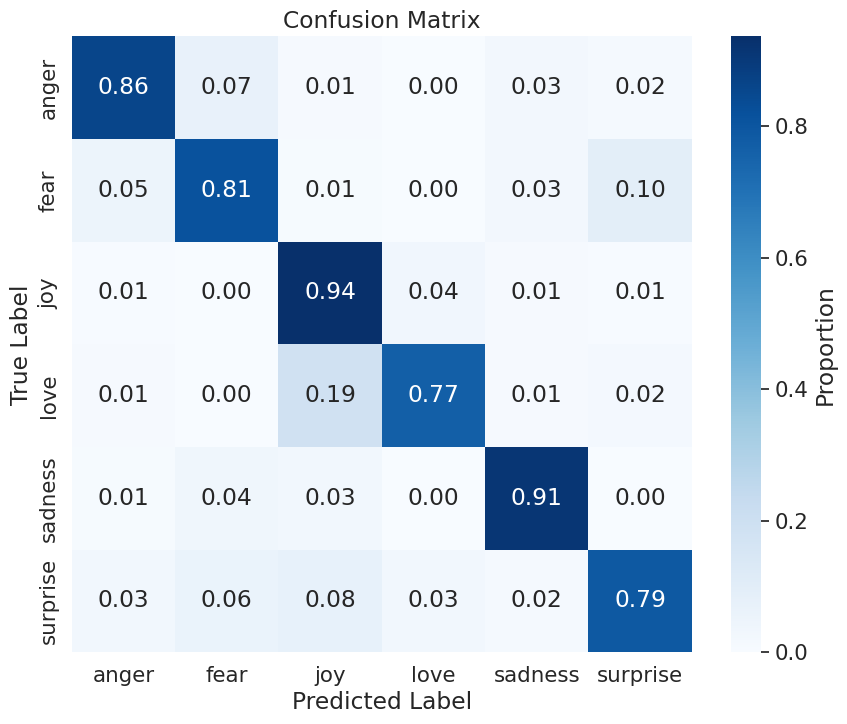

In [63]:
# Visualize training history
show_history(history_model_cnn)

# Evaluating the model
loss, accuracy = model_cnn.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_cnn.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_cnn, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(y_test, y_pred_classes_cnn, classes=list(labels_dict.values()))

**Bidirectional LSTM Model 2**


In [64]:
import tensorflow as tf

def create_bidirectional_lstm_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    return model


model_bidirectional_lstm = create_bidirectional_lstm_model(vocab_size, embedding_dim, max_len)

model_bidirectional_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bidirectional_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [65]:
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train,
                                                           y_train,
                                                           epochs=15,
                                                           batch_size=32,
                                                           validation_data=(X_val, y_val),
                                                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.3688 - loss: 1.5297 - val_accuracy: 0.7075 - val_loss: 0.7370
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7864 - loss: 0.6156 - val_accuracy: 0.8595 - val_loss: 0.4336
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8948 - loss: 0.3215 - val_accuracy: 0.8900 - val_loss: 0.3586
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9290 - loss: 0.2188 - val_accuracy: 0.8970 - val_loss: 0.3645
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9433 - loss: 0.1724 - val_accuracy: 0.8990 - val_loss: 0.3779
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9649 - loss: 0.1198 - val_accuracy: 0.8980 - val_loss: 0.4075


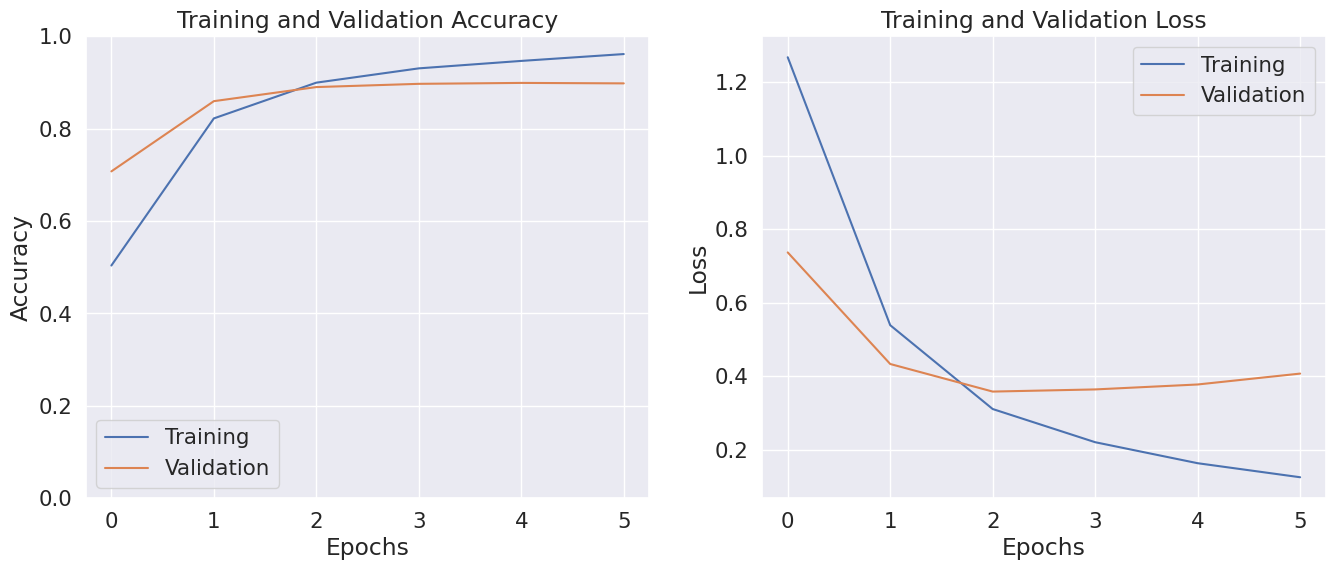

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8852 - loss: 0.3478
Test Loss: 0.3476974666118622
Test Accuracy: 0.8880000114440918
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.81      0.86       275
        fear       0.84      0.88      0.86       224
         joy       0.92      0.93      0.92       695
        love       0.70      0.86      0.77       159
     sadness       0.95      0.92      0.93       581
    surprise       0.61      0.59      0.60        66

    accuracy                           0.89      2000
   macro avg       0.82      0.83      0.83      2000
weighted avg       0.89      0.89      0.89      2000



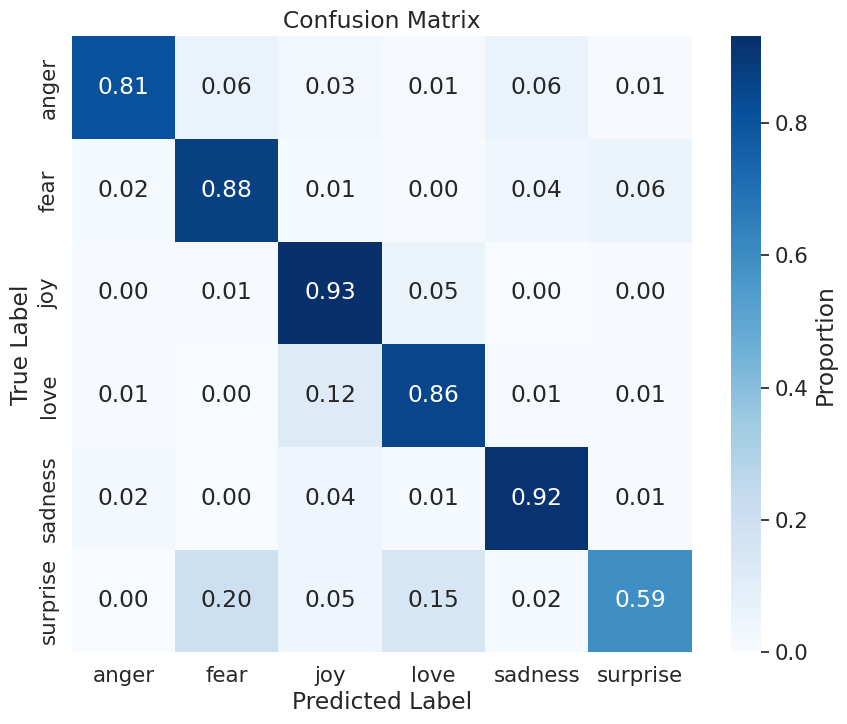

In [66]:
# Visualize training history
show_history(history_bidirectional_lstm)

# Evaluating the model
loss, accuracy = model_bidirectional_lstm.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_bidirectional_lstm.predict(X_test)
y_pred_classes_bilstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_bilstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(y_test, y_pred_classes_bilstm, classes=list(labels_dict.values()))

# **CNN+LSTM**



In [67]:
def create_cnn_lstm_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    return model

cnn_lstm_model = create_cnn_lstm_model(vocab_size, embedding_dim, input_length=max_len)

cnn_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3240 - loss: 1.5975 - val_accuracy: 0.3640 - val_loss: 1.1542
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4500 - loss: 1.0692 - val_accuracy: 0.6750 - val_loss: 0.8367
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7307 - loss: 0.6480 - val_accuracy: 0.7515 - val_loss: 0.5398
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8032 - loss: 0.4030 - val_accuracy: 0.7970 - val_loss: 0.6029
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8156 - loss: 0.3627 - val_accuracy: 0.7515 - val_loss: 0.8584
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8321 - loss: 0.3196 - val_accuracy: 0.7995 - val_loss: 0.5943
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8611 - loss: 0.2504 - val_accuracy: 0.8030 - val_loss: 0.6583
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8706 - loss: 0.2298 - val_acc

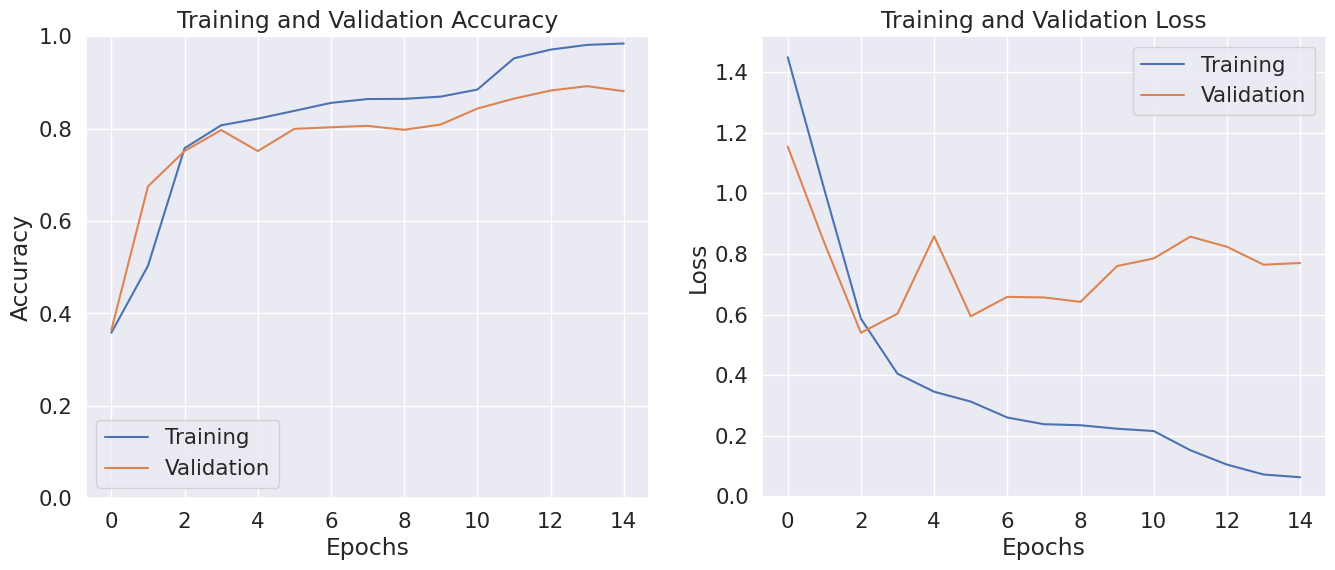

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.6877
Test Loss: 0.6684140563011169
Test Accuracy: 0.8889999985694885
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.90      0.87       275
        fear       0.88      0.78      0.83       224
         joy       0.92      0.92      0.92       695
        love       0.80      0.82      0.81       159
     sadness       0.92      0.92      0.92       581
    surprise       0.67      0.76      0.71        66

    accuracy                           0.89      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.89      0.89      0.89      2000



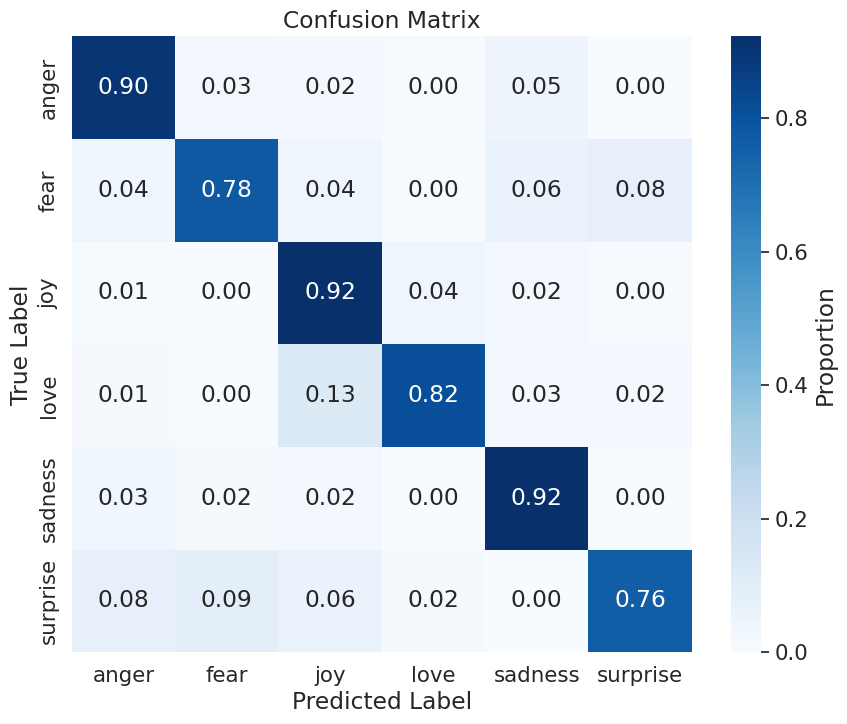

In [69]:
# Visualize training history
show_history(history_cnn_lstm)

# Evaluating the model
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = cnn_lstm_model.predict(X_test)
y_pred_classes_cnn_lstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_cnn_lstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(y_test, y_pred_classes_cnn_lstm, classes=list(labels_dict.values()))

In [70]:
def create_improved_gru_cnn_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),

        Bidirectional(GRU(128, return_sequences=True)),
        BatchNormalization(),

        Conv1D(filters=512, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=512, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        GlobalMaxPooling1D(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer for 6 classes
        Dense(6, activation='softmax')
    ])
    return model


In [71]:
model_gru_cnn_g_k = create_improved_gru_cnn_model(vocab_size, embedding_dim, max_len)

model_gru_cnn_g_k.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_gru_cnn_g_k.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
history_model_gru_cnn = model_gru_cnn_g_k.fit(
    X_train,
    y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_encoded),
    callbacks=[]
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.3298 - loss: 2.0712 - val_accuracy: 0.1795 - val_loss: 6.9470
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8832 - loss: 0.3710 - val_accuracy: 0.9065 - val_loss: 0.2862
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9398 - loss: 0.1729 - val_accuracy: 0.8895 - val_loss: 0.3333
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9493 - loss: 0.1501 - val_accuracy: 0.8905 - val_loss: 0.3586
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9612 - loss: 0.1227 - val_accuracy: 0.8910 - val_loss: 0.3775
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9682 - loss: 0.0953 - val_accuracy: 0.8870 - val_loss: 0.4364
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9707 - loss: 0.0930 - val_accuracy: 0.8950 - val_loss: 0.4292
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9707 - loss: 0.0902 - 

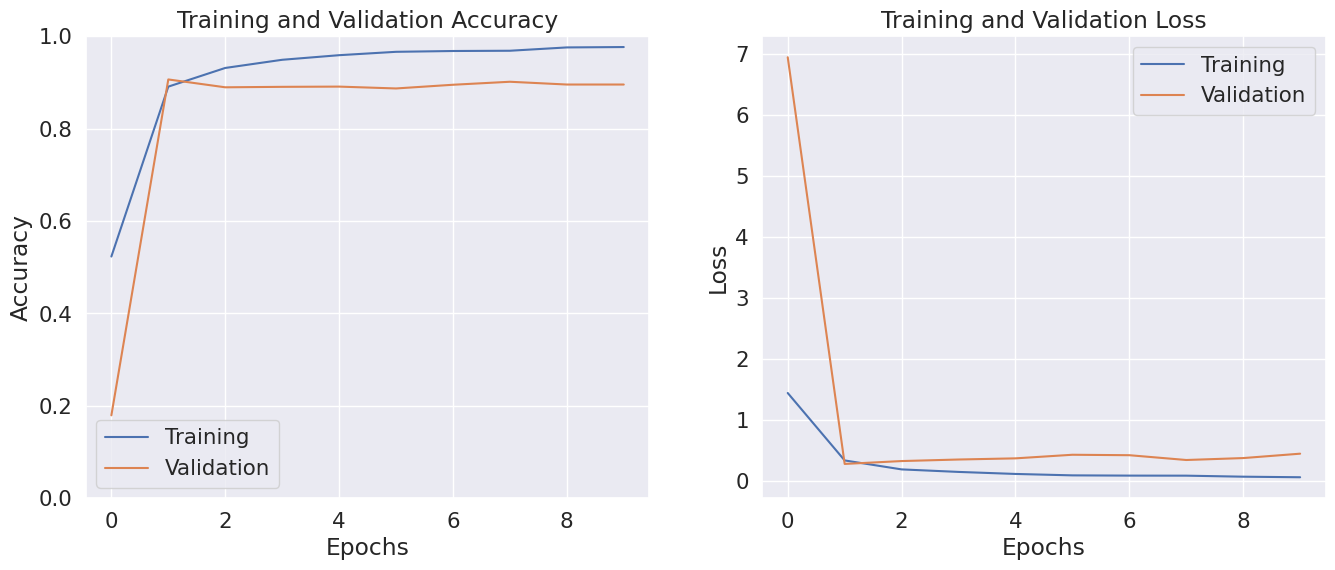

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8956 - loss: 0.4262
Test Loss: 0.41296055912971497
Test Accuracy: 0.8964999914169312
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.84      0.91      0.88       275
        fear       0.86      0.88      0.87       224
         joy       0.94      0.90      0.92       695
        love       0.71      0.89      0.79       159
     sadness       0.96      0.92      0.94       581
    surprise       0.85      0.70      0.77        66

    accuracy                           0.90      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.90      0.90      0.90      2000



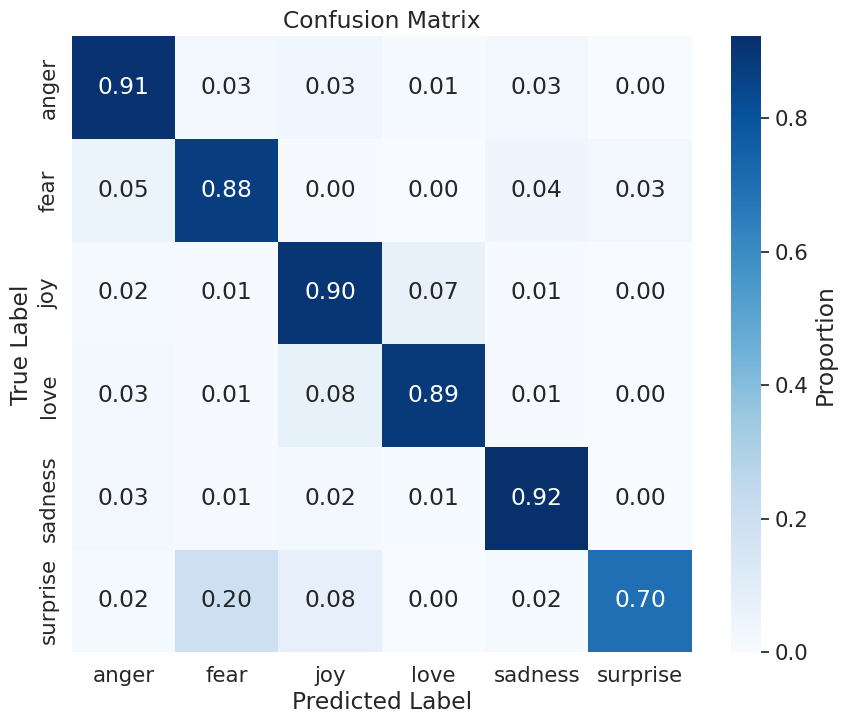

In [73]:
# Visualize training history
show_history(history_model_gru_cnn)

# Evaluate the model on the test set
loss, accuracy = model_gru_cnn_g_k.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_gru_cnn_g_k.predict(X_test)
y_pred_classes_gru_cnn = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes_gru_cnn, target_names=list(labels_dict.values())))

# Display confusion matrix
show_confusion_matrix(y_test, y_pred_classes_gru_cnn, classes=list(labels_dict.values()))

# **PREDICTIONS**

In [ ]:
# Saving the trained model
model_enhanced_gru.save('tweet_classification_model_gru_91_accuracy.h5')
print("Model saved successfully.")

Model saved successfully.


In [74]:
from tensorflow.keras.models import load_model
def load_model_from_file(filename):
    model = load_model(filename)
    print(f'Model loaded from {filename}')
    return model

In [76]:
loaded_model = load_model_from_file('/content/tweet_classification_model_gru_91_accuracy.h5')

Model loaded from /content/tweet_classification_model_gru_91_accuracy.h5


In [75]:
def predict_emotion(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    padded_input = pad_sequences(input_seq, maxlen=41)
    prediction = loaded_model.predict(padded_input)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

In [80]:
while True:
    user_input = input("Enter a sentence to predict emotion (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    predicted_class = predict_emotion(user_input)
    emotion = list(labels_dict.values())[predicted_class]  # Get the emotion label from the dictionary
    print(f'Predicted Emotion: {emotion}')

Enter a sentence to predict emotion (or type 'exit' to quit): exit


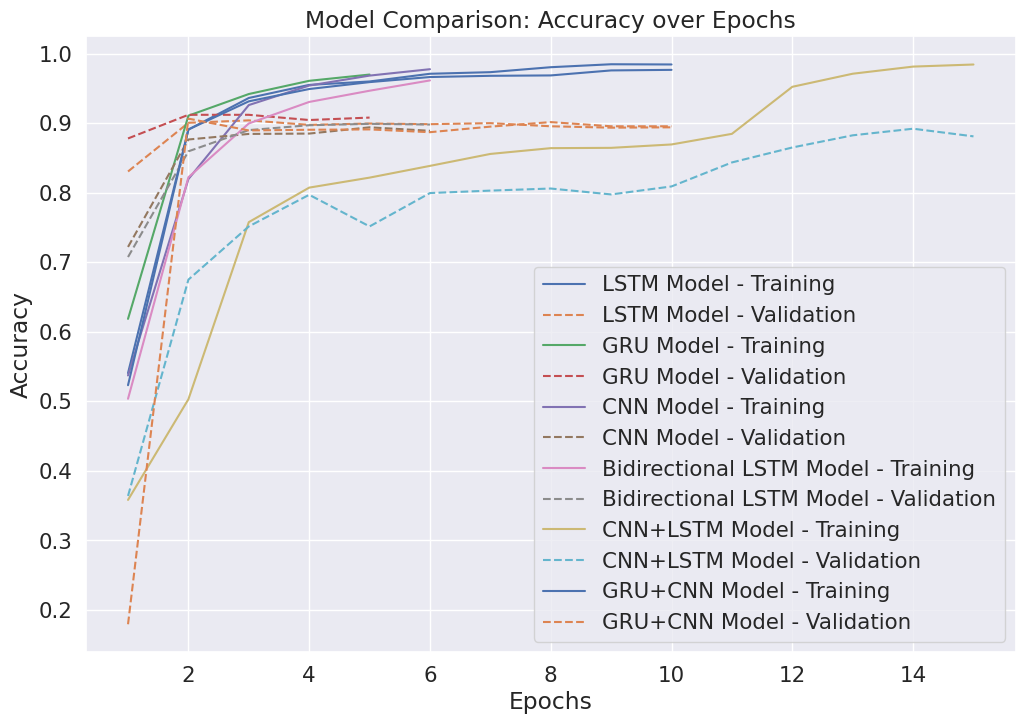

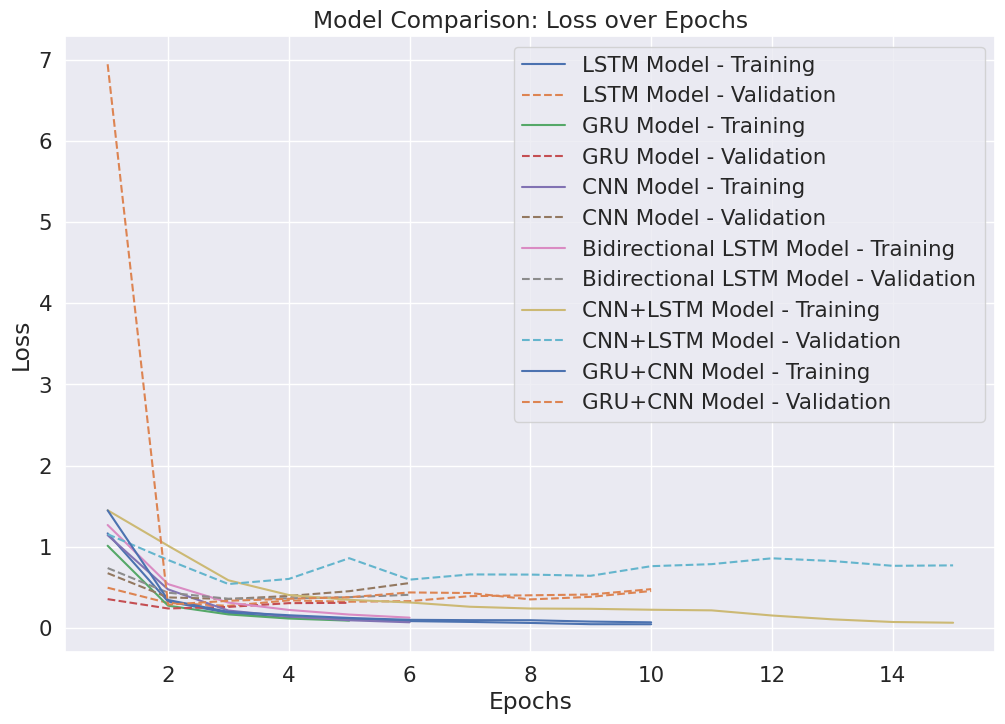

In [81]:
import matplotlib.pyplot as plt

def plot_comparative_metrics(histories, metric, title, ylabel):
    plt.figure(figsize=(12, 8))
    for model_name, history in histories.items():
        epochs = range(1, len(history.history[metric]) + 1)
        plt.plot(epochs, history.history[metric], label=f'{model_name} - Training')
        plt.plot(epochs, history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - Validation')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

model_histories = {
    "LSTM Model": history_model_lstm_1,
    "GRU Model": history_model_gru,
    "CNN Model": history_model_cnn,
    "Bidirectional LSTM Model": history_bidirectional_lstm,
    "CNN+LSTM Model": history_cnn_lstm,
    "GRU+CNN Model": history_model_gru_cnn
}

plot_comparative_metrics(model_histories, 'accuracy', 'Model Comparison: Accuracy over Epochs', 'Accuracy')
plot_comparative_metrics(model_histories, 'loss', 'Model Comparison: Loss over Epochs', 'Loss')


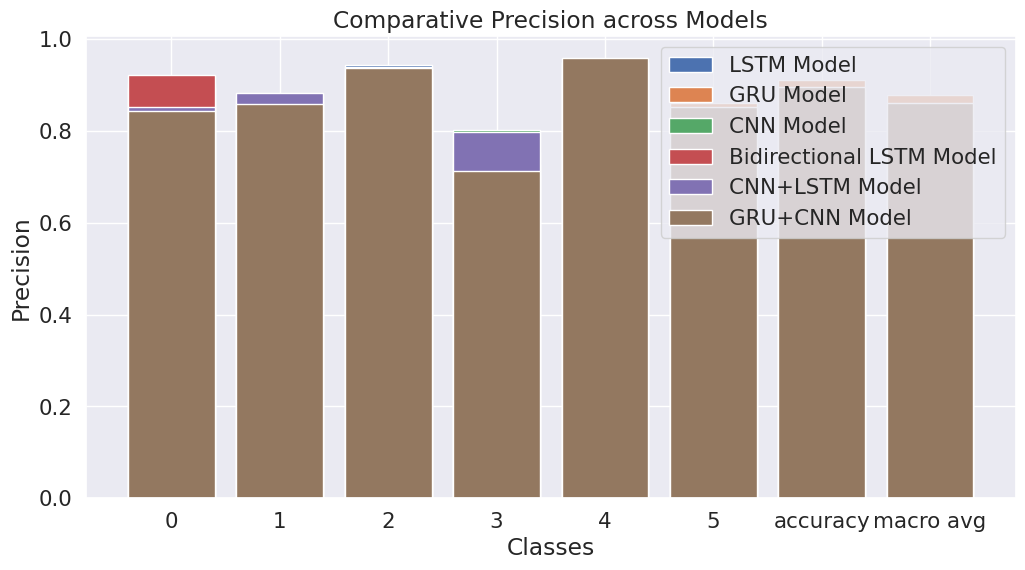

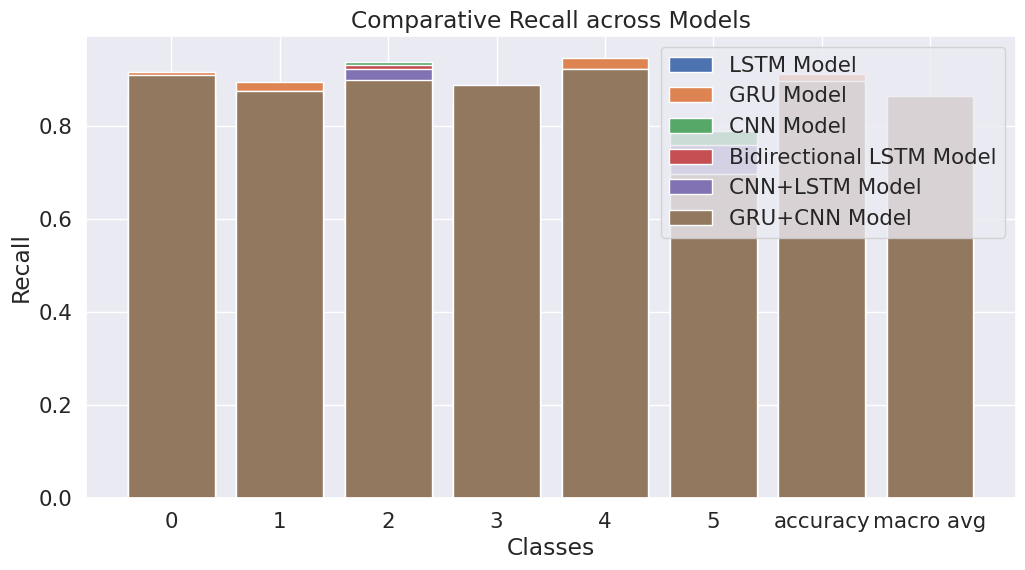

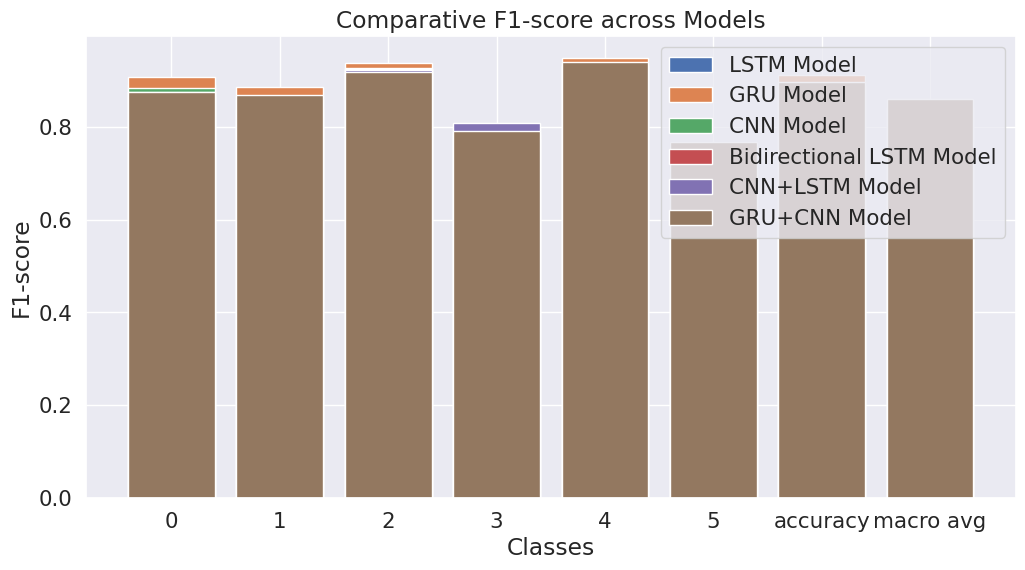

In [83]:
from sklearn.metrics import classification_report
import pandas as pd

model_predictions = {
    "LSTM Model": y_pred_classes_lstm,
    "GRU Model": y_pred_classes_gru,
    "CNN Model": y_pred_classes_cnn,
    "Bidirectional LSTM Model": y_pred_classes_bilstm,
    "CNN+LSTM Model": y_pred_classes_cnn_lstm,
    "GRU+CNN Model": y_pred_classes_gru_cnn
}

metrics_df = pd.DataFrame()
for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df["model"] = model_name
    metrics_df = pd.concat([metrics_df, df])

# Plot the metrics
for metric in ["precision", "recall", "f1-score"]:
    plt.figure(figsize=(12, 6))
    for model_name in model_predictions.keys():
        plt.bar(
            metrics_df[metrics_df["model"] == model_name].index[:-1],
            metrics_df[metrics_df["model"] == model_name][metric][:-1],
            label=model_name
        )
    plt.title(f'Comparative {metric.capitalize()} across Models')
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()
